In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from transformers import CLIPModel, CLIPProcessor, Trainer, TrainingArguments
from torchvision import transforms
import os
from torch.utils.data import Dataset
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

from utils import compute_metrics, compute_additional_metrics, plot_confusion_matrix, compute_all_metrics_with_ci

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class FractureDataset(Dataset):
    def __init__(self, case_ids, labels, root_dir,processor=None):
        self.case_ids = case_ids
        self.labels = labels
        self.root_dir = root_dir
        self.processor = processor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        case_id, label = self.case_ids[idx], self.labels[idx]
        case_folder = os.path.join(self.root_dir, case_id)
        subfolders = os.listdir(case_folder)
        assert len(subfolders) == 1, f"Expected 1 subfolder in {case_folder}, found {subfolders}"
        inner_folder = os.path.join(case_folder, subfolders[0])

        # Load images
        image_paths = [os.path.join(inner_folder, f) for f in os.listdir(inner_folder) if f.endswith('.jpg')]
        images = []
        for image_path in image_paths:
            image = Image.open(image_path)
            images.append(image)

        # Load text
        text_file = next((f for f in os.listdir(inner_folder) if f.endswith(".txt")), None)
        assert text_file is not None, f"No text file found in {inner_folder}"
        with open(os.path.join(inner_folder, text_file), "r", encoding="utf-8") as f:
            full_text = f.read().strip()

        # Process images and text
        processed = self.processor(
            text=full_text,
            images=images,
            return_tensors="pt",
            padding='max_length',
            truncation=True,
            max_length=77, 
        )

        label = torch.tensor(label, dtype=torch.float).unsqueeze(0)

        return {
            "input_ids": processed["input_ids"].squeeze(0),
            "attention_mask": processed["attention_mask"].squeeze(0),
            "pixel_values": processed["pixel_values"][0],
            "text": full_text,
            "image": images[0],  # Return the first image for simplicity
            "labels": label,
            "case_id": case_id
        }

In [3]:
root_dir = "AI FRACTURES"

# Create a processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

with open("fracture_data_split.pkl", "rb") as f:
    split_data = pickle.load(f)

train_dataset = FractureDataset(split_data["train"], split_data["train_labels"], root_dir, processor)
test_dataset = FractureDataset(split_data["test"], split_data["test_labels"], root_dir, processor)
val_dataset = FractureDataset(split_data["val"], split_data["val_labels"], root_dir, processor)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
class Model_CLIP(nn.Module):
    def __init__(self, model_name="openai/clip-vit-base-patch32", num_labels=1):
        super(Model_CLIP, self).__init__()

        self.clip = CLIPModel.from_pretrained(model_name)

        for param in self.clip.parameters():
            param.requires_grad = False
        
        embedding_size = self.clip.config.projection_dim

        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(embedding_size*2, num_labels)

        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        outputs = self.clip(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, return_dict=True)
        text_embeddings = outputs.text_embeds
        image_embeddings = outputs.image_embeds

        # Concatenate
        fused_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        # Pass through classifier
        logits = self.classifier(self.dropout(fused_embeddings))

        result = {"logits": logits}

        loss = None
        if labels is not None:
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            result["loss"] = loss

        return result
        
    def state_dict(self, *args, **kwargs):
        state_dict = super().state_dict(*args, **kwargs)
        # Make the visual_projection.weight tensor contiguous
        if "clip.visual_projection.weight" in state_dict:
            state_dict["clip.visual_projection.weight"] = state_dict["clip.visual_projection.weight"].contiguous()
        # Make the text_projection.weight tensor contiguous
        if "clip.text_projection.weight" in state_dict:
            state_dict["clip.text_projection.weight"] = state_dict["clip.text_projection.weight"].contiguous()
        return state_dict

In [5]:
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "pixel_values": pixel_values,
        "labels": labels
    }

In [6]:
model = Model_CLIP(num_labels=1)

# Training setup
training_args = TrainingArguments(
    output_dir='./clip_fracture_output',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=5e-2,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator = collate_fn,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [7]:
trainer.train()
print("Training complete.")

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,0.693300,0.690062,0.500000,0.000000,0.500000
2,0.685500,0.680859,0.500000,0.000000,0.500000
3,0.664000,0.667880,0.500000,0.000000,0.500000
4,0.647000,0.649916,0.500000,0.000000,0.500000
5,0.605000,0.631626,0.500000,0.000000,0.500000
6,0.569200,0.595384,0.500000,0.000000,0.500000
7,0.536800,0.577344,0.600000,0.333333,0.600000
8,0.496000,0.543042,0.600000,0.333333,0.600000
9,0.463100,0.511871,0.700000,0.571429,0.700000
10,0.432100,0.501863,0.600000,0.333333,0.600000


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [8]:
torch.save(model.state_dict(), "clip_fracture_model.pth")

In [9]:
# Save the model
trainer.save_model()

# Evaluate the model
trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.5118710398674011,
 'eval_accuracy': 0.7,
 'eval_f1': 0.5714285714285714,
 'eval_roc_auc': 0.7,
 'eval_runtime': 5.0872,
 'eval_samples_per_second': 1.966,
 'eval_steps_per_second': 0.393,
 'epoch': 10.0}

In [7]:
model.load_state_dict(torch.load("clip_fracture_model.pth"))

<All keys matched successfully>

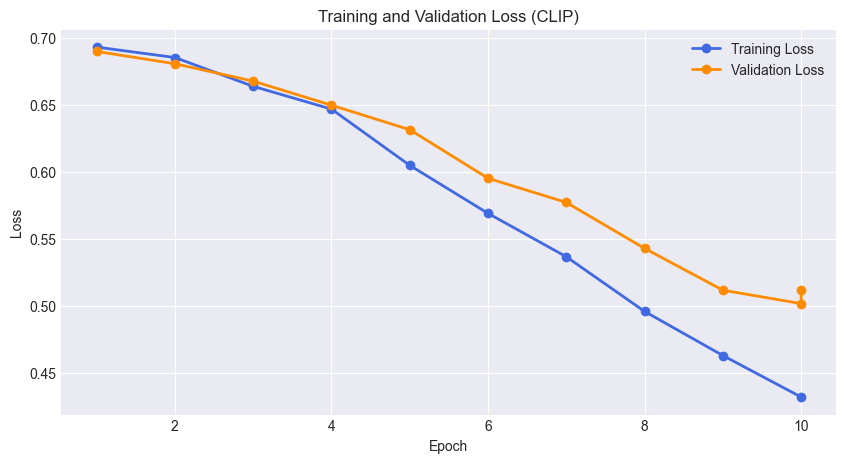

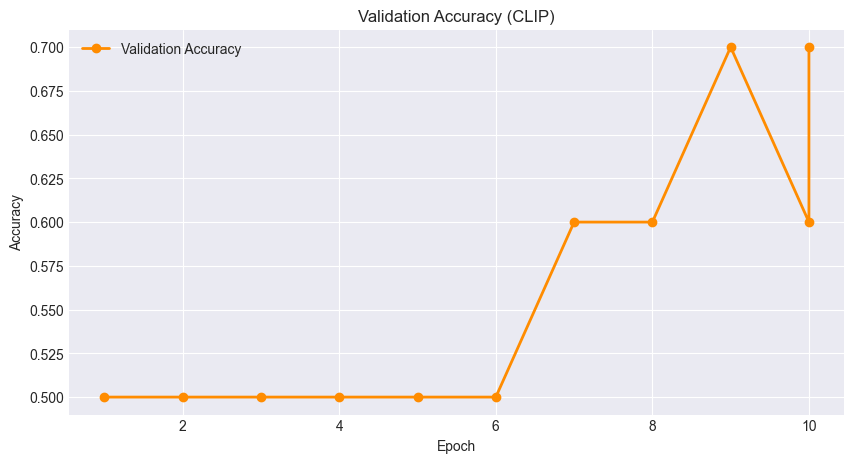

In [11]:
# Extract logs
logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []
train_epochs = []
eval_epochs = []

for log in logs:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])  # store matching epoch
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.style.use('seaborn-v0_8-darkgrid')
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label="Training Loss", marker='o', linewidth=2, color='royalblue')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o', linewidth=2, color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (CLIP)")
plt.legend()
plt.grid(True)
plt.savefig("clip_fracture_loss.png")
plt.show()

# Plot Accuracy (optional, if accuracy was computed)
if eval_accuracy:
    plt.figure(figsize=(10, 5))
    plt.plot(eval_epochs[:len(eval_accuracy)], eval_accuracy, label="Validation Accuracy", marker='o', linewidth=2, color='darkorange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy (CLIP)")
    plt.legend()
    plt.grid(True)
    plt.savefig("clip_fracture_accuracy.png")
    plt.show()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


f1: 0.8889
roc_auc: 0.9000
matthews_corrcoef: 0.8165
brier_score: 0.1000
sensitivity: 0.8000
specificity: 1.0000
balanced_accuracy: 0.9000


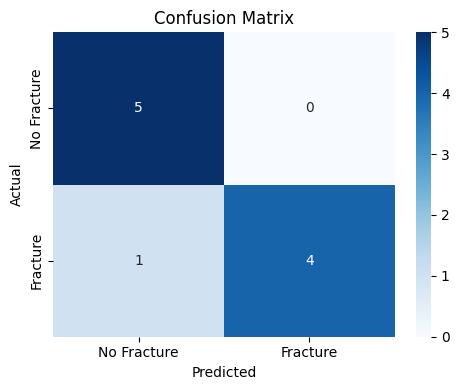

In [8]:
# Run evaluation
predictions = trainer.predict(test_dataset)

# Extract logits and compute probabilities using sigmoid if binary
logits = predictions.predictions
y_pred_probs = 1 / (1 + np.exp(-logits))  # Sigmoid for binary
y_pred_probs = y_pred_probs.squeeze()    # Remove extra dimension if needed
y_pred = (y_pred_probs >= 0.5).astype(int)  # Get predicted class labels

# Ground truth labels
y_true = predictions.label_ids.squeeze()

# Compute and print metrics
metrics = compute_additional_metrics(y_true, y_pred)
for key, value in metrics.items():
    if key != "confusion_matrix":
        print(f"{key}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"])

In [11]:
print("Confidence scores for test set:")
for i, score in enumerate(y_pred_probs):
    if y_pred[i] == 1:
        print(f"Sample {i+1}: {score:.4f} confidence for fracture")
    else:
        print(f"Sample {i+1}: {1-score:.4f} confidence for no fracture")

Confidence scores for test set:
Sample 1: 0.6160 confidence for fracture
Sample 2: 0.5282 confidence for no fracture
Sample 3: 0.7038 confidence for no fracture
Sample 4: 0.6020 confidence for no fracture
Sample 5: 0.6103 confidence for fracture
Sample 6: 0.6775 confidence for fracture
Sample 7: 0.5834 confidence for no fracture
Sample 8: 0.6556 confidence for fracture
Sample 9: 0.5461 confidence for no fracture
Sample 10: 0.5096 confidence for no fracture


In [13]:
results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=False)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnin

Error computing sensitivity for bootstrap sample
not enough values to unpack (expected 4, got 1)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Error computing specificity for bootstrap sample
not enough values to unpack (expected 4, got 1)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was 

accuracy: 0.903 (90% CI: 0.700 - 1.000)
f1: 0.867 (90% CI: 0.600 - 1.000)
auroc: 0.837 (90% CI: 0.520 - 1.000)
mcc: 0.806 (90% CI: 0.509 - 1.000)
brier: 0.103 (90% CI: 0.000 - 0.300)
sensitivity: 0.809 (90% CI: 0.500 - 1.000)
specificity: 1.000 (90% CI: 1.000 - 1.000)
balanced_accuracy: 0.898 (90% CI: 0.700 - 1.000)


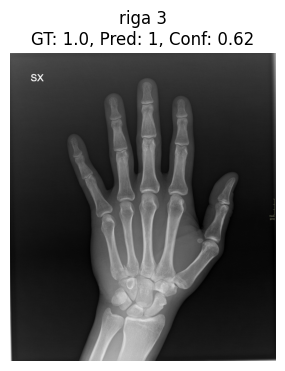

Report: Frattura lievemente scomposta e ingranata della base del V metacarpo.
Rapporti articolari congrui.
GT: 1.0, Pred: 1, Confidence: 0.6160
----------------------------------------


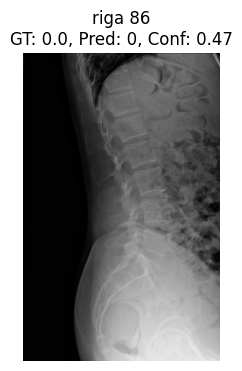

Report: Rx rachide Sacrococcigeo
Rx Rachide Lombosacrale
Con i limiti intrinseci della metodica, non evidenti rime di frattura.
GT: 0.0, Pred: 0, Confidence: 0.4718
----------------------------------------


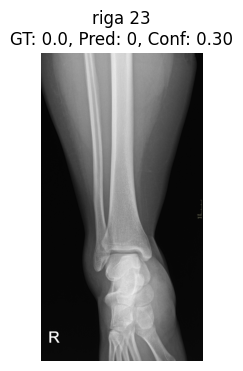

Report: RX caviglia destra
Non evidenti rime di frattura in atto.
Conservati i rapporti articolari.
GT: 0.0, Pred: 0, Confidence: 0.2962
----------------------------------------


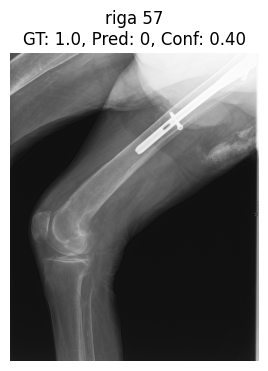

Report: Ginocchio destro
Frattura diametaepifisaria distale del femore, articolare, con modesto ingranamento e angolazione dei frammenti.
Esiti di osteosintesi femorale prossimale.
Torace. Indagine eseguita in AP, a Paziente supina.
Non si documentano franche immagini riferibili ad addensamenti parenchimali di significato flogistico in atto.
Diffusa accentuazione del disegno polmonare.
Nei limiti il circolo polmonare.
L'immagine cardiaca appare ingrandita con salienza dell'arco inferiore di sinistra.
Calcificazioni parietali aortiche.
GT: 1.0, Pred: 0, Confidence: 0.3980
----------------------------------------


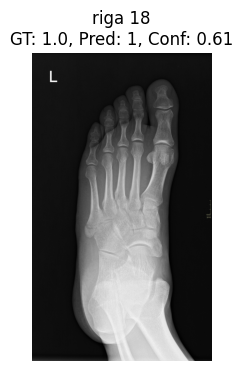

Report: RX piede sinistro
Frattura della base del V metatarsale.
GT: 1.0, Pred: 1, Confidence: 0.6103
----------------------------------------


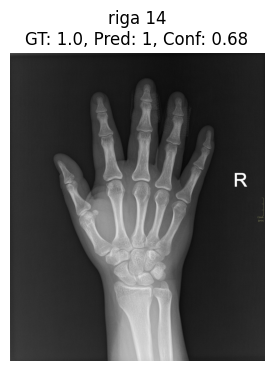

Report: Mano destra
Frattura sostanzialmente composta metaepifisaria distale della falange intermedia del IV raggio. Non lussazioni.
GT: 1.0, Pred: 1, Confidence: 0.6775
----------------------------------------


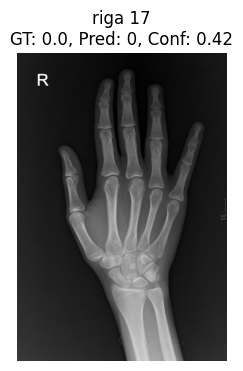

Report: RX IV raggio mano destra
Non evidenti rime di frattura in atto.
Conservati i rapporti articolari; atteggiamento in flessione dell'articolazione interfalangea prossimale.
GT: 0.0, Pred: 0, Confidence: 0.4166
----------------------------------------


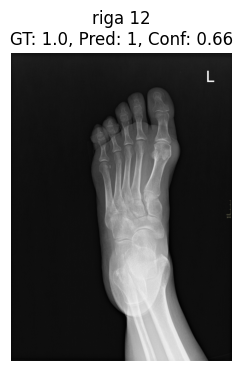

Report: Piede sinistro
Frattura articolare metaepifisaria distale della falange prossimale del V raggio, lievemente ingranata.
Frattura composta alla falange ungueale del V raggio.
Non lussazioni.
GT: 1.0, Pred: 1, Confidence: 0.6556
----------------------------------------


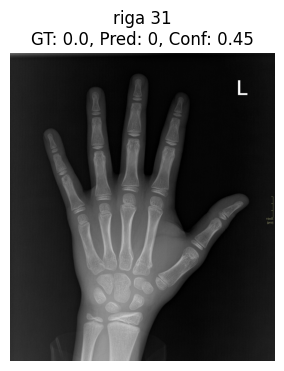

Report: RX II dito mano sinistra
Non evidenti rime di frattura in atto.
Conservati i rapporti articolari.
GT: 0.0, Pred: 0, Confidence: 0.4539
----------------------------------------


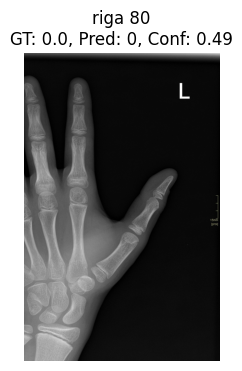

Report: Rx Mano sx
Non immagini riferibili a rime di frattura.
Regolari i rapporti articolari.
GT: 0.0, Pred: 0, Confidence: 0.4904
----------------------------------------


In [10]:
import matplotlib.pyplot as plt

for i in range(len(y_true)):
    sample = test_dataset[i]
    # Use the original PIL image for display
    img = sample["image"]
    report = sample.get("text", "No report available")
    case_id = sample.get("case_id", f"Sample {i+1}")
    gt = y_true[i]
    pred = y_pred[i]
    conf = y_pred_probs[i]

    # Plot image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{case_id}\nGT: {gt}, Pred: {pred}, Conf: {conf:.2f}")
    plt.show()

    # Print report and output
    print(f"Report: {report}")
    print(f"GT: {gt}, Pred: {pred}, Confidence: {conf:.4f}\n{'-'*40}")

In [14]:
# from torchview import draw_graph
# from PIL import Image
# dummy_image = Image.new('RGB', (224, 224))

# # Create dummy text
# dummy_text = "a sample description"

# # Use the processor to get the proper inputs
# dummy_inputs = processor(text=dummy_text, images=dummy_image, return_tensors="pt", padding="max_length", truncation=True, max_length=77)

# model = Model_CLIP(num_labels=1)
# model.eval()  # Set the model to evaluation mode

# # Pass the inputs to your model (unpack the dictionary)
# output = model(
#     input_ids=dummy_inputs["input_ids"],
#     attention_mask=dummy_inputs["attention_mask"],
#     pixel_values=dummy_inputs["pixel_values"]
# )

# model_graph = draw_graph(
#     model,
#     input_data={
#         "input_ids": dummy_inputs["input_ids"],
#         "attention_mask": dummy_inputs["attention_mask"],
#         "pixel_values": dummy_inputs["pixel_values"],
#     },
#     graph_name='CLIP Fracture Model Graph',
#     save_graph=True,
#     expand_nested=False
# )

In [15]:
def generate_visual_explanation(model, processor, dataset, idx):
    model.eval()

    torch.set_grad_enabled(True)
    
    # Get a single data point and add batch dimension
    item = dataset[idx]
    pixel_values = item["pixel_values"].unsqueeze(0)
    input_ids = item["input_ids"].unsqueeze(0)
    attention_mask = item["attention_mask"].unsqueeze(0)

    # --- Forward pass ---
    output = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
    logits = output["logits"]

    # --- Backward pass to get gradients ---
    # We use the logit as the score to backpropagate from
    logits.backward()

    # Get the gradients and activations from the hook
    gradients = model.get_activations_gradient()
    activations = model.get_activations()
    
    # Pool the gradients across the patches
    pooled_gradients = torch.mean(gradients, dim=[0, 1])

    # Weight the channels of the activations by the gradients
    # (batch_size, num_patches, hidden_size) -> (num_patches, hidden_size)
    activations = activations.squeeze(0)
    for i in range(activations.size(0)):
        activations[i, :] *= pooled_gradients[i]

    # Average the channels to get the heatmap
    heatmap = torch.mean(activations, dim=1).detach().cpu()
    
    # The CLIP vision transformer outputs include a [CLS] token at the beginning
    # We should ignore it for the heatmap visualization
    heatmap = heatmap[1:] # Exclude the [CLS] token
    
    # Reshape to a 2D grid and normalize
    num_patches_side = int(np.sqrt(heatmap.shape[0]))
    heatmap = heatmap.reshape(num_patches_side, num_patches_side)
    heatmap = F.relu(heatmap) # Apply ReLU
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.numpy()

    # --- Visualization ---
    original_img = item["image"]
    original_img_np = np.array(original_img)

    # Resize heatmap and create an overlay
    heatmap_resized = cv2.resize(heatmap, (original_img_np.shape[1], original_img_np.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    
    superimposed_img = np.uint8(heatmap_colored * 0.4 + original_img_np)

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(original_img_np)
    ax1.set_title("Original Image")
    ax1.axis('off')

    ax2.imshow(superimposed_img)
    ax2.set_title("Grad-CAM Explanation")
    ax2.axis('off')
    # plt.savefig("grad_cam_explanation.png")
    plt.tight_layout()
    plt.show()

In [16]:
def generate_text_explanation(model, processor, dataset, idx):
    """
    Generates a more robust text explanation using Gradient x Input method.
    """
    model.eval()
    torch.set_grad_enabled(True)
    model.zero_grad()

    # Get a single data point and add batch dimension
    item = dataset[idx]
    pixel_values = item["pixel_values"].unsqueeze(0)
    input_ids = item["input_ids"].unsqueeze(0)
    attention_mask = item["attention_mask"].unsqueeze(0).to(torch.bool)

    # We need the initial embeddings before they are passed into the transformer layers
    # This is model.clip.text_model.embeddings.word_embeddings
    
    # Let's get the word embeddings and mark them for gradient calculation
    initial_embeddings = model.clip.text_model.embeddings(input_ids)
    initial_embeddings.requires_grad = True
    
    # --- Manual Forward Pass for Text ---
    # Now we pass these initial embeddings through the rest of the text model
    encoder = model.clip.text_model.encoder
    final_token_embeddings = encoder(initial_embeddings, attention_mask=attention_mask)[0]

    # Pool the output from the CLS token, as per CLIP's architecture
    pooled_output = final_token_embeddings[:, 0, :]
    text_embeds = model.clip.text_projection(pooled_output)
    
    # --- Vision Forward Pass (no gradients needed here) ---
    with torch.no_grad():
        vision_outputs = model.clip.vision_model(pixel_values=pixel_values)
        image_embeds = model.clip.visual_projection(vision_outputs.pooler_output)

    # --- Final Classification and Backward Pass ---
    fused = torch.cat((text_embeds, image_embeds), dim=1)
    logits = model.classifier(fused)
    
    # Backpropagate to our initial embeddings
    logits.backward()
    
    # --- Calculate Importance Scores ---
    # The gradient is now in initial_embeddings.grad
    # Score = (gradient * input_embedding).sum(dim=-1)
    saliency = (initial_embeddings.grad * initial_embeddings).sum(dim=-1).squeeze(0)
    
    # Normalize the scores
    saliency = saliency / saliency.norm(p=1)
    saliency = saliency.detach().cpu().numpy()

    # --- Visualization ---
    tokens = processor.tokenizer.convert_ids_to_tokens(item["input_ids"])
    
    # For better visualization, let's clean up the tokens and aggregate sub-word scores
    clean_tokens = []
    aggregated_scores = []
    current_word = ""
    current_score = 0
    
    for token, score in zip(tokens, saliency):
        if token in ("<|startoftext|>", "<|endoftext|>"):
            continue # Skip special tokens for the plot
            
        if token.endswith('</w>'):
            current_word += token[:-4]
            current_score += score
            clean_tokens.append(current_word)
            aggregated_scores.append(current_score)
            current_word = ""
            current_score = 0
        else:
            current_word += token
            current_score += score
            
    # Create a pandas series for easier plotting
    scores_series = pd.Series(aggregated_scores, index=clean_tokens)
    
    plt.figure(figsize=(10, 8))
    scores_series.sort_values().plot(kind='barh', color='skyblue')
    plt.title("Text Token Importance (Gradient x Input)")
    plt.xlabel("Importance Score")
    # plt.savefig("text_importance_scores.png")
    plt.show()

In [17]:
# n = 18
# generate_visual_explanation(model, processor, test_dataset, n)
# generate_text_explanation(model, processor, test_dataset, n)